In [2]:
import gymnasium as gym
import tensorflow as tf
from tensorflow.keras import layers, models
import keras

import numpy as np
import random
from collections import deque


ACTIONS_ALL = {  
        0: 'LANE_LEFT',  
        1: 'IDLE',  
        2: 'LANE_RIGHT',  
        3: 'FASTER',  
        4: 'SLOWER'  
    }

- OBSERVATION / STATE: 5 x 5 (VxF) array  
 - V = Anzahl Cars, erste Zeile ego car  
 - F = größe Features, hier: presence,x, y, vx, vy  (presence 0 oder 1, 0 wenn platzhalter und kein auto da ist)  
 - Normalisierte Werte  
 - (The coordinates are relative to the ego-vehicle, except for the ego-vehicle which stays absolute.)  
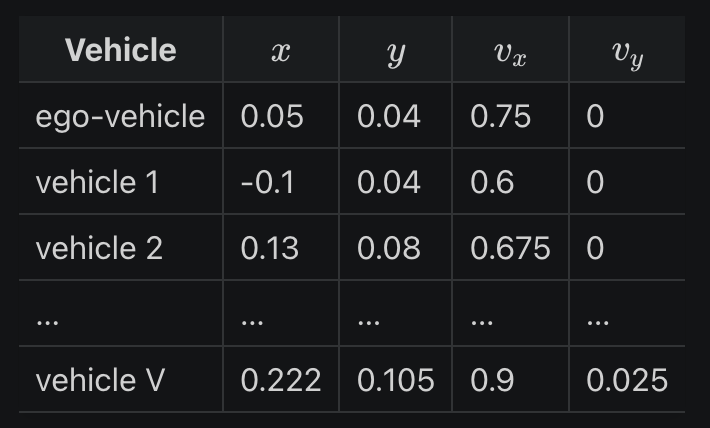

Rewards sind normalisiert.  
- Collision: -1
- Right lane reward: 0.1
- Speed Reward: Die Speed vom Car [20, 30] m/s wird lineaer abgebildet auf den Reward [0, 0.4]

In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense 
import numpy as np

In [4]:
STATE_SHAPE = (24, ) # Single state is an array with 24 elements (after conversion)
ACTION_SIZE = 5      # Number of actions

model = Sequential([
    Dense(units=64, input_shape=STATE_SHAPE, activation="relu", name="hidden1"),
    Dense(units=64, activation="relu", name="hidden2"),
    Dense(units=5, activation="relu", name="output")
])
model.compile(loss="mse", optimizer="adam")

model.summary()

/Users/verleih/Documents/Dev/reinforcement-learning-gym/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 64)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,085 (23.77 KB)

 Trainable params: 6,085 (23.77 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, InputLayer, Lambda

# Define the preprocessing function
def preprocess_input(x):
    x = tf.reshape(x, [-1])  # Flatten the input
    x = x[1:]  # Remove the first element
    return x

# Define the model
model = Sequential([
    InputLayer(input_shape=(5, 5), name="input"),  # Explicit input layer
    Lambda(preprocess_input, name="preprocessing"),
    Dense(units=24, activation="relu", name="hidden1"),
    Dense(units=24, activation="relu", name="hidden2"),
    Dense(units=5, name="output")  # Output layer for 5 actions
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Print the model summary
model.summary()

# Generate random data for prediction with different batch sizes
batch_size_1 = np.random.rand(1, 5, 5)  # Batch size of 1
batch_size_3 = np.random.rand(3, 5, 5)  # Batch size of 3

# Predict with batch size 1
output_1 = model.predict(batch_size_1)
print(f"Output for batch size 1:\n{output_1}\n")

# Predict with batch size 3
output_3 = model.predict(batch_size_3)
print(f"Output for batch size 3:\n{output_3}\n")


/Users/verleih/Documents/Dev/reinforcement-learning-gym/.venv/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


ValueError: Input 0 of layer "hidden1" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)

In [1]:
class ReplayBuffer():
    def __init__(self, capacity):
        self._states = deque(maxlen=capacity)
        self._actions = deque(maxlen=capacity)
        self._rewards = deque(maxlen=capacity)
        self._next_states = deque(maxlen=capacity)
        self._dones = deque(maxlen=capacity)

    def __len__(self):
        return len(self._states)

    def append(self, state, action, reward, next_state, done):
        self._states.append(state)
        self._actions.append(action)
        self._rewards.append(reward)
        self._next_states.append(next_state)
        self._dones.append(done)
        
    def sample(self, batch_size):
        indices = random.sample(range(len(self._states)), batch_size)

        states = np.array([self._states[i] for i in indices])
        actions = np.array([self._actions[i] for i in indices])
        rewards = np.array([self._rewards[i] for i in indices])
        next_states = np.array([self._next_states[i] for i in indices])
        dones = np.array([float(self._dones[i]) for i in indices])
        
        return states, actions, rewards, next_states, dones

In [93]:
class DQNAgent():
    def __init__(self, 
                 env, 
                 is_training, 
                 replay_buffer_size, 
                 batch_size, 
                 model,
                 gamma,
                 epsilon_start,
                 epsilon_min,
                 epsilon_decay):
        
        self.loss_func = keras.losses.MeanSquaredError
        
        self.env = env
        self.is_training = is_training

        self.replay_buffer = ReplayBuffer(capacity=replay_buffer_size)
        self.batch_size = batch_size

        self.policy_net = model
        self.target_net = model
        self.gamma = gamma

        self.epsilon_start = epsilon_start
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

    def act(self, state):
        """The agents policy using the Epsilon-Greedy Algorithm. If not training only exploits."""
        if (self.is_training and random.uniform(0, 1) < self.epsilon):
            return self.env.action_space.sample() # Choose random action
        else:
            state = np.array(state).reshape((1, 24))
            q_values = self.policy_net.predict(state) # Forwardpropagation - returns q values
            best_action = np.argmax(q_values)
            return best_action # Choose action with highest q value

    def learn(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(64)

        # Build the updated Q-values for the sampled future states
        # Use the target model for stability
        future_rewards = self.target_net.predict(next_states)
        # Q value = reward + discount factor * expected future reward
        updated_q_values = rewards + self.gamma * keras.ops.amax(future_rewards, axis=1)

        # If final frame set the last value to -1
        updated_q_values = updated_q_values * (1 - dones) - dones

        # Create a mask so we only calculate loss on the updated Q-values
        masks = keras.ops.one_hot(actions, 5)

        with tf.GradientTape() as tape:
            # Train the model on the states and updated Q-values
            q_values = self.policy_net(states)

            # Apply the masks to the Q-values to get the Q-value for action taken
            q_action = keras.ops.sum(keras.ops.multiply(q_values, masks), axis=1)
            # Calculate loss between new Q-value and old Q-value
            loss = loss_function(updated_q_values, q_action)

        # Backpropagation
        grads = tape.gradient(loss, self.policy_net.trainable_variables)
        optimizer.apply_gradients(zip(grads, self.policy_net.trainable_variables))

    def update_target_net(self):
        """Copies weights and biases from policy to target network."""
        self.target_net.set_weights(self.policy_net.get_weights())

    def decay_epsilon(self, current_episode, total_episodes):
        decay_rate = (self.epsilon_start - self.epsilon_min) / total_episodes
        self.epsilon = max(self.epsilon_min, self.epsilon_start - decay_rate * current_episode)
  

### Utils

In [150]:
def preprocess_state(state):
    state = np.array(state) # Convert list to numpy array
    state = state.flatten() # Convert 5x5 array into one array
    state = state[1:] # Cut out first element, because it's always '1'
    return state

In [8]:
env = gym.make("highway-v0")

# ----- Parameters -----
TOTAL_EPISODES = 6_000

LEARNING_RATE = 0.01
GAMMA = 0.99
EPSILON_START = 1
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.95

REPLAY_BUFFER_SIZE = 2000
BATCH_SIZE = 32
TARGET_UPDATE_FREQ = 100

state_size = 24  # Assuming state has 24 elements
action_size = env.action_space.n

model = build_model(state_size, action_size)
agent = DQNAgent(env, True, REPLAY_BUFFER_SIZE, BATCH_SIZE, model, EPSILON_START, EPSILON_MIN, EPSILON_DECAY)

# Episodes
for episode in range(TOTAL_EPISODES):
    state, _ = env.reset()
    terminated = False
    truncated = False
    step = 0
    total_reward = 0

    # Steps
    while not (terminated or truncated):
        action = agent.act(state)
        new_state, reward, terminated, truncated, _ = env.step(action)

        agent.replay_buffer.append(state, action, reward, new_state, terminated or truncated)
        agent.learn()
        agent.update_target_net()

        state = new_state
        step += 1
        total_reward += reward

    agent.decay_epsilon(episode, TOTAL_EPISODES)
    print(f"Episode: {episode+1}/{TOTAL_EPISODES}, Score: {total_reward}, Epsilon: {agent.epsilon:.2}")

env.close()

NameError: name 'gym' is not defined